## Due date: Friday, 2 April 2021, 11:59 PM


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import time
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [2]:
from os.path import abspath
path = 'F:\\UNIVERSITY\\4TH_SEM\\Assignments\\LaTeX Report\\figures\\'

def saveto(filename):
    plt.savefig(path+ filename)

def saveimg(filename, image):
    cv.imwrite(path+ filename,image)

def sigmoid(hypothesis):
    return 1/(1+ np.exp(-hypothesis))

def getAccuracy(predictions,labels):
    pred_class = np.argmax(predictions, axis=1)
    real_class = np.argmax(labels, axis=1)
    valid_pred = [pred_class == real_class]
    return np.sum(valid_pred)/len(real_class) # 0-1


In [3]:
# Loading the Data Set
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print('x_train: ', x_train.shape); print('y_train: ', y_train.shape)

print("Pre-processing loaded data...\n")
# y_train contains labels form 0 to 9 corresponding to 10 classes.
K = len(np.unique(y_train)) # Number of Classes

Ntr = x_train.shape[0]; print('Number of training samples:', Ntr) # Number of training samples 50,000
Nte = x_test.shape[0];  print('Number of test samples: ',Nte,'\n')# Number of test samples 10,000
Din = 3072 # CIFAR10 # 32x32x3 = height x width x channel

# Normalize pixel values: Image data preprocessing
x_train, x_test = x_train / 255.0, x_test / 255.0
mean_image = np.mean(x_train, axis=0) # axis=0: mean of a column; Mean of each pixel
x_train = x_train - mean_image
x_test = x_test - mean_image

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes=K); print('y_train: ', y_train.shape); #print(y_train[0:10,:])
y_test =  tf.keras.utils.to_categorical(y_test,  num_classes=K);

x_train = np.reshape(x_train,(Ntr,Din)).astype('float32')
x_test = np.reshape(x_test,(Nte,Din)).astype('float32')
print('Reshaped x_train: ', x_train.shape)
print('Reshaped x_test: ', x_test.shape)
print("Pre-processing completed.")

x_train:  (50000, 32, 32, 3)
y_train:  (50000, 1)
Pre-processing loaded data...

Number of training samples: 50000
Number of test samples:  10000 

y_train:  (50000, 10)
Reshaped x_train:  (50000, 3072)
Reshaped x_test:  (10000, 3072)
Pre-processing completed.


# Part 1

[Reference1](https://cs231n.github.io/linear-classify/)

A part of the code for a linear classifier for CIFAR10 given in listing 1. For our linear classifier, the score function is f (x) = Wx + b, and the loss function is the mean sum of squared errors function. [3 marks]
1. Implement gradient descent and run for 300 epochs.
2. Show the weights matrix W as 10 images.
3. Report the (initial) learning rate, training and testing loss and accuracies.

(Hint: If your loss explodes, reduce the leaning rate.)
* [np.unique](https://numpy.org/doc/stable/reference/generated/numpy.unique.html), [np.mean](https://numpy.org/doc/stable/reference/generated/numpy.mean.html), [tf.keras.utils.to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical), [np.random.randn](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html), [numpy.argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html)

In [4]:
print("Initializing the weight matrix with random weights...")
std=1e-5 # For random samples from N(\mu, \sigma^2), use: sigma * np.random.randn(...) + mu
w1 = std*np.random.randn(Din, K) # Initializing the weight matrix with random weights
b1 = np.zeros(K) # Initializing the bias vector
print("w1:", w1.shape);print("b1:", b1.shape)

# Keep track of two sets of parameters w1 and b1 seperately is not really efficient.
# This can be eiliminated by combining both of them into one single matrix as follows.
# Aditionally the bias term '1' must be added infront of each image row, for this to wrok.
# i.e to enable matrix multiplication.

print("Rearranging train and test samples...")

# Rearranging train and test samples: (ra=rearranged)
x_train_ra = np.concatenate((np.ones((x_train.shape[0],1)),x_train), axis=1); print('Rearranged x_train: ', x_train_ra.shape)
x_test_ra  = np.concatenate((np.ones((x_test.shape[0],1)),x_test), axis=1)

# Rearranging weight matrix and bias matrix into single matrix
w1 = np.concatenate((b1.reshape(1,K), w1), axis=0); print('Rearranged w1: ',w1.shape)

print("Rearranging completed.\n")

#------------------------------------------------------------------------------------------

iterations = 300  # Gradient descent interations
lr = 1.4e-2 # Learninig rate
lr_decay= 0.999
reg = 5e-6

loss_history = [] # Vlaues of loss function at each iteration 
test_loss = []
train_acc_history = [] # Training accuracy
val_acc_history = [] # Validation accuracy


m = x_train.shape[0]  # Number of training examples
m2 = x_test_ra.shape[0]

# Running gradient descent number of times speciied in iterations
print("Running gradient descent...")

for t in range(1,iterations+1):    
    # Forward Propagation
    hypothesis = x_train_ra.dot(w1)
    loss = (1/(2*m))*np.sum(( hypothesis - y_train)**2) + (1/(2*m))*reg*np.sum(w1**2) 
    loss_history.append(loss)
    
    # Backward Propagation
    dw1 = (1/m)*(x_train_ra.T.dot(hypothesis - y_train))  + (1/m)*reg*w1 
    w1 = w1 - lr*dw1
    
    
    # Training Accuracy and Validation Accuracy
    train_acc = getAccuracy(hypothesis, y_train)
    train_acc_history.append(train_acc)
    valid_acc = getAccuracy(x_test_ra.dot(w1), y_test)
    val_acc_history.append(valid_acc)
   
    # Test Loss    
    t_loss = (1/(2*m2))*np.sum(( x_test_ra.dot(w1) - y_test)**2) + (1/(2*m2))*reg*np.sum(w1**2) 
    test_loss.append(t_loss)
    
    # Print details for selected iterations
    if (t%30==0) or (t==1):
        print("| Epoch {:03} | Loss {:.4f} | accuracy: {:.4f} | val_loss: {:.4f} | val_accuracy: {:.4f} |"\
             .format(t, loss, train_acc, t_loss, valid_acc))
    
    
    # Decaying learning rate
    lr = lr*lr_decay
    
print("Gradient Descent completed. Parameters were trained")   

Initializing the weight matrix with random weights...
w1: (3072, 10)
b1: (10,)
Rearranging train and test samples...
Rearranged x_train:  (50000, 3073)
Rearranged w1:  (3073, 10)
Rearranging completed.

Running gradient descent...
| Epoch 001 | Loss 0.5000 | accuracy: 0.0842 | val_loss: 0.4846 | val_accuracy: 0.2485 |
| Epoch 030 | Loss 0.4297 | accuracy: 0.3648 | val_loss: 0.4287 | val_accuracy: 0.3640 |
| Epoch 060 | Loss 0.4126 | accuracy: 0.3810 | val_loss: 0.4123 | val_accuracy: 0.3814 |
| Epoch 090 | Loss 0.4049 | accuracy: 0.3896 | val_loss: 0.4049 | val_accuracy: 0.3889 |
| Epoch 120 | Loss 0.4010 | accuracy: 0.3954 | val_loss: 0.4012 | val_accuracy: 0.3921 |
| Epoch 150 | Loss 0.3987 | accuracy: 0.3993 | val_loss: 0.3992 | val_accuracy: 0.3938 |
| Epoch 180 | Loss 0.3973 | accuracy: 0.4020 | val_loss: 0.3980 | val_accuracy: 0.3953 |
| Epoch 210 | Loss 0.3964 | accuracy: 0.4047 | val_loss: 0.3972 | val_accuracy: 0.3962 |
| Epoch 240 | Loss 0.3957 | accuracy: 0.4065 | val_loss: 

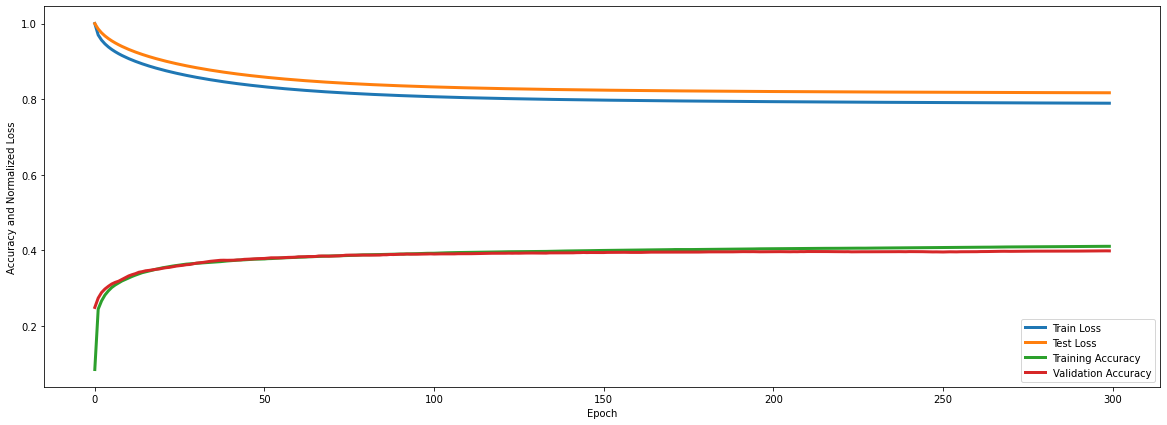

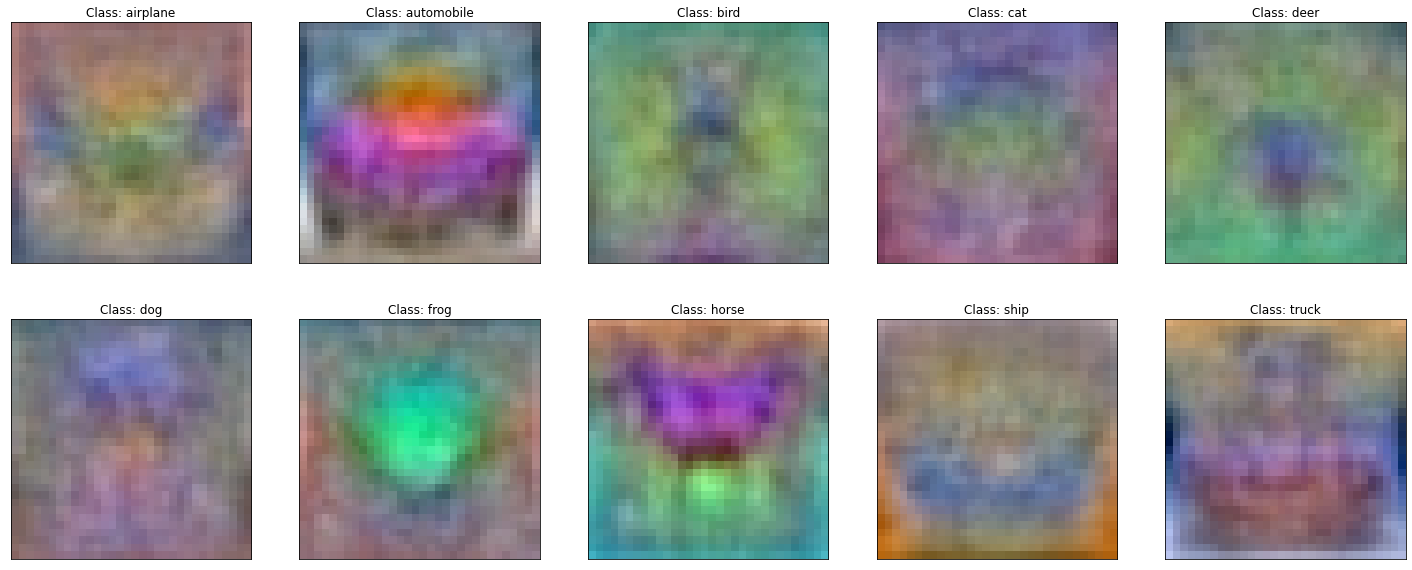

In [5]:
# ------Plotting learning rate, training and testing loss and accuracies-------
#fig, axes  = plt.subplots(1,2, sharex='all', sharey='all', figsize=(20,7))
plt.figure(figsize=(20,7))
plt.plot(loss_history/np.max(loss_history), linewidth=3, label = 'Train Loss')
plt.plot(test_loss/np.max(test_loss), linewidth=3, label = 'Test Loss')
plt.plot(train_acc_history, linewidth=3, label = "Training Accuracy")
plt.plot(val_acc_history,  linewidth=3, label =  "Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy and Normalized Loss')
plt.legend(loc='lower right')
# saveto("part1plots.eps")

# items = {"Train Loss":loss_history, "Test Loss":test_loss, "Training Accuracy":train_acc_history,\
#          "Validation Accuracy": val_acc_history}

# location = 1
# for key in items.keys():
#     plt.subplot(1,4,location);plt.plot(items[key], color='#0000ff', linewidth=4)
#     plt.title(key)
#     location+=1


# -------------------Showing the weights matrix W1 as 10 images-----------------
weights = w1[1:,] # Removing the row of bias terms.
weights_pos =  weights- np.min(weights)# Making the minimum weight zero.
images = ((weights_pos/np.max(weights_pos))*255).astype('uint8')
CIFAR10 = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
fig, axes  = plt.subplots(2,5, sharex='all', sharey='all', figsize=(25,10))
location = 1 # Location of the image in the grid of 2x5
for i in range(K):
    image = images[:,i].reshape(32,32,3)
    plt.subplot(2,5,location),plt.imshow(image[:,:,::-1])
    plt.title("Class: {}".format(CIFAR10[i])),plt.xticks([]),plt.yticks([])    
    #saveimg("Reg Image "+ str(i)+".jpg", image)
    location+=1
# saveto("trainedWeightsp1.eps")

# Part 2
Code a two-layer fully connected network with H = 200 hidden nodes. Choose the sigmoid function as the activation function for the hidden nodes. The output layer has no activation function. [3 marks]

1. Implement gradient descent and run for 300 epochs.
2. Report the (initial) learning rate, training and testing loss and accuracies.

In [6]:
# Loading the Data Set
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print('x_train: ', x_train.shape); print('y_train: ', y_train.shape)
#print(y_train[0:10])

print("Pre-processing loaded data...\n")
# y_train contains labels form 0 to 9 corresponding to 10 classes.
K = len(np.unique(y_train)) # Number of Classes

Ntr = x_train.shape[0]; print('Number of training samples:', Ntr) # Number of training samples 50,000
Nte = x_test.shape[0]; print('Number of test samples: ',Nte,'\n')      # Number of test samples 10,000
Din = 3072 # CIFAR10 # 32x32x3 = height x width x channel

# Image data preprocessing
"""
Remove the normalization. Otherwise the model will not learn.
Because when the weights are extrememly small,
weight matrix will consist of almost the same elements.
and learning will stop.
"""
#x_train, x_test = x_train / 255.0, x_test / 255.0
mean_image = np.mean(x_train, axis=0) # axis=0: mean of a column; Mean of each pixel
x_train = x_train - mean_image
x_test = x_test - mean_image

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes=K); print('y_train: ', y_train.shape); #print(y_train[0:10,:])
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K); #print(y_test[0:10,:])

x_train = np.reshape(x_train,(Ntr,Din)).astype('float32');# print(x_train[0:10, 0:20])
x_test = np.reshape(x_test,(Nte,Din)).astype('float32')
print('Reshaped x_train: ', x_train.shape)
print('Reshaped x_test: ', x_test.shape)
print("Pre-processing completed.")

x_train:  (50000, 32, 32, 3)
y_train:  (50000, 1)
Pre-processing loaded data...

Number of training samples: 50000
Number of test samples:  10000 

y_train:  (50000, 10)
Reshaped x_train:  (50000, 3072)
Reshaped x_test:  (10000, 3072)
Pre-processing completed.


In [7]:
H = 200 # No of hidden nodes
print("Initializing the weight matrix with random weights...")
std=1e-5 # For random samples from N(\mu, \sigma^2), use: sigma * np.random.randn(...) + mu

# Hidden Layer 
w1 = std*np.random.randn(Din, H) # Initializing the weight matrix with random weights
b1 = np.zeros(H) # Initializing the bias vector
print("w1:", w1.shape);print("b1:", b1.shape)

# Last Layer
w2 = std*np.random.randn(H, K) # Initializing the weight matrix with random weights
b2 = np.zeros(K) # Initializing the bias vector
print("w2:", w2.shape);print("b2:", b2.shape)

print("Rearranging train and test samples...")
# Rearranging train and test samples: (ra=rearranged)
x_train_ra = np.concatenate((np.ones((x_train.shape[0],1)),x_train), axis=1); print('Rearranged x_train: ', x_train_ra.shape)
x_test_ra  = np.concatenate((np.ones((x_test.shape[0],1)),x_test), axis=1)

# Rearranging weight matrices and bias vectors into single matrices
w1 = np.concatenate((b1.reshape(1,H), w1), axis=0); print('Rearranged w1: ',w1.shape)
w2 = np.concatenate((b2.reshape(1,K), w2), axis=0); print('Rearranged w2: ',w2.shape)

print("Rearranging completed.")

iterations = 300  # Gradient descent interations
lr = 1.4e-2 # Learninig rate
lr_decay= 0.999
reg = 5e-6
test_loss = []
loss_history = [] # Vlaues of cost function at each iteration 
train_acc_history = []
val_acc_history = []

m = x_train.shape[0]  # Number of training examples
m2 = x_test_ra.shape[0]
# Running gradient descent number of times speciied in iterations
print("Running gradient descent...")

for t in range(1,iterations+1):
    # Forward Propagation
    hypo = sigmoid(x_train_ra.dot(w1)) # Layer 1 with sigmoid activation
    hypothesis = np.concatenate((np.ones((hypo.shape[0],1)),hypo), axis=1) # Rearranging for layer 2
    predict = hypothesis.dot(w2) # Layer 2 
    
    loss = (1/(2*m))*np.sum(( predict - y_train)**2)\
         + (1/(2*m))*reg*np.sum(w1**2) + (1/(2*m))*reg*np.sum(w2**2)
    loss_history.append(loss)
    
    # Back Propagation partial dertivatives of Loss function
    # (dl/dw2) = (dl/dpredict)(dpredic/dw2)
    dpredict =  (1/m)*(predict - y_train)
    dw2 = hypothesis.T.dot(dpredict) + (1/m)*reg*w2
    
    # (dl/dw1) = (dl/dh)(dh/dw1)
    # (dl/dw1) = (dl/dpredict)(dpredic/dh) * (dh/dw1x)(dw1x/dw1)
    dh = dpredict.dot(w2[1:,].T) # Removing bias vector w2(201x10)--> 200x10
    dhdxw1 = hypo*(1 - hypo) #using hypothesis 50000*200 before rearranging.
    dw1 = x_train_ra.T.dot(dh*dhdxw1) + (1/m)*reg*w1
    
    # Gradient Descent
    w1 = w1 - lr*dw1
    w2 = w2 - lr*dw2
    
    # Training Accuracy 
    train_acc = getAccuracy(predict, y_train)
    train_acc_history.append(train_acc)
    
    # Validation Accuracy
    test_hypo = sigmoid(x_test_ra.dot(w1))
    test_hypothesis = np.concatenate((np.ones((test_hypo.shape[0],1)),test_hypo), axis=1)# Rearranging for layer 2
    test_predict = test_hypothesis.dot(w2)
    valid_acc = getAccuracy(test_predict, y_test)
    val_acc_history.append(valid_acc)
    
    # Test Loss    
    t_loss = (1/(2*m2))*np.sum(( test_predict- y_test)**2)\
         + (1/(2*m2))*reg*np.sum(w1**2) + (1/(2*m2))*reg*np.sum(w2**2)
    test_loss.append(t_loss)
    
    # Print details for selected iterations
    if (t%30==0) or (t==1):
        print("| Epoch {:03} | Loss {:.4f} | accuracy: {:.4f} | val_loss: {:.4f} | val_accuracy: {:.4f} |"\
             .format(t, loss, train_acc, t_loss, valid_acc))
        
    # Decaying learning rate

    lr = lr*lr_decay
    
print("Gradient Descent completed. Parameters were trained")

Initializing the weight matrix with random weights...
w1: (3072, 200)
b1: (200,)
w2: (200, 10)
b2: (10,)
Rearranging train and test samples...
Rearranged x_train:  (50000, 3073)
Rearranged w1:  (3073, 200)
Rearranged w2:  (201, 10)
Rearranging completed.
Running gradient descent...
| Epoch 001 | Loss 0.5000 | accuracy: 0.1000 | val_loss: 0.4541 | val_accuracy: 0.1005 |
| Epoch 030 | Loss 0.4202 | accuracy: 0.2740 | val_loss: 0.4203 | val_accuracy: 0.2718 |
| Epoch 060 | Loss 0.4101 | accuracy: 0.3362 | val_loss: 0.4097 | val_accuracy: 0.3352 |
| Epoch 090 | Loss 0.4034 | accuracy: 0.3539 | val_loss: 0.4034 | val_accuracy: 0.3545 |
| Epoch 120 | Loss 0.3943 | accuracy: 0.3891 | val_loss: 0.3955 | val_accuracy: 0.3832 |
| Epoch 150 | Loss 0.3898 | accuracy: 0.4039 | val_loss: 0.3913 | val_accuracy: 0.4040 |
| Epoch 180 | Loss 0.3880 | accuracy: 0.4071 | val_loss: 0.3897 | val_accuracy: 0.4013 |
| Epoch 210 | Loss 0.3846 | accuracy: 0.4180 | val_loss: 0.3868 | val_accuracy: 0.4115 |
| Epo

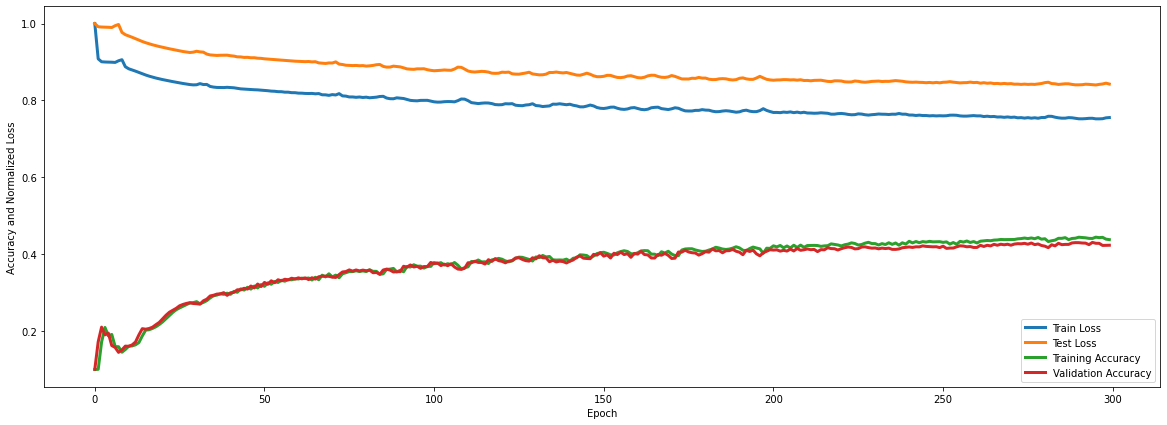

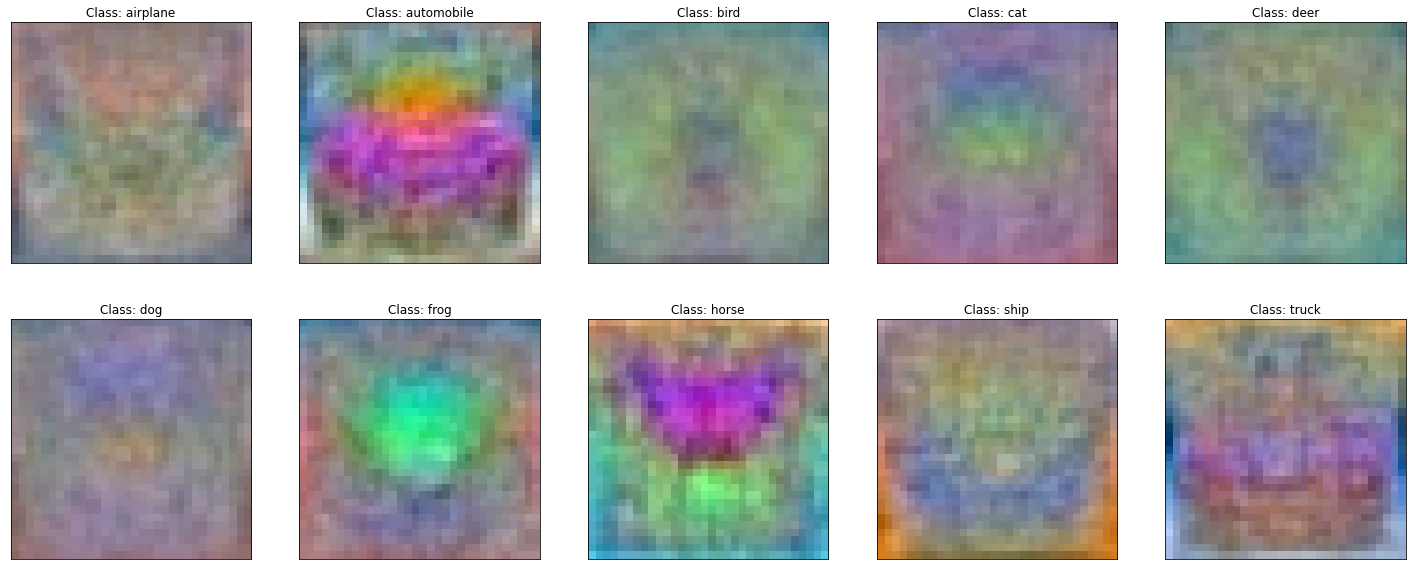

In [8]:
# ------Plotting learning rate, training and testing loss and accuracies-------
# fig, axes  = plt.subplots(1,4, sharex='all', sharey='all', figsize=(30,6))
# items = {"Loss":loss_history, "Training Accuracy":train_acc_history,\
#          "Validation Accuracy": val_acc_history, "Learning Rate":lr_hitory}
# location = 1
# for key in items.keys():
#     plt.subplot(1,4,location);plt.plot(items[key], color='#0000ff', linewidth=3)
#     plt.title(key)
#     location+=1
plt.figure(figsize=(20,7))
plt.plot(loss_history/np.max(loss_history), linewidth=3, label = 'Train Loss')
plt.plot(test_loss/np.max(test_loss), linewidth=3, label = 'Test Loss')
plt.plot(train_acc_history, linewidth=3, label = "Training Accuracy")
plt.plot(val_acc_history,  linewidth=3, label =  "Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy and Normalized Loss')
plt.legend(loc='lower right')    
# saveto("part2plots.eps")

# -------------------Showing the weights matrix W1.W2 as 10 images-----------------
weights = w1[1:,].dot(w2[1:,]) # Removing the rows of bias terms.
weights_pos =  weights- np.min(weights)# Making the minimum weight zero.
images = ((weights_pos/np.max(weights_pos))*255).astype('uint8')
CIFAR10 = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
fig, axes  = plt.subplots(2,5, sharex='all', sharey='all', figsize=(25,10))
location = 1 # Location of the image in the grid of 2x5
for i in range(K):
    image = images[:,i].reshape(32,32,3)
    plt.subplot(2,5,location),plt.imshow(image[:,:,::-1])
    plt.title("Class: {}".format(CIFAR10[i])),plt.xticks([]),plt.yticks([])    
#     saveimg("Reg Image "+ str(i)+".jpg", image)
    location+=1
# saveto("trainedWeightsnn2.eps")

# Part 3

Modify the code in item 2 to carry out stochastic gradient descent with a batch size of 500. [2 marks]
1. Report training and testing loss and accuracies.
2. Compare results with item2 (justify).

[Reference](https://realpython.com/gradient-descent-algorithm-python/#minibatches-in-stochastic-gradient-descent)

* Stochastic gradient descent randomly divides the set of observations into minibatches.
* For each minibatch, the gradient is computed and the vector is moved.
* Once all minibatches are used, you say that the iteration, or epoch, is finished and start the next one.

In [9]:
# Loading the Data Set
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print('x_train: ', x_train.shape); print('y_train: ', y_train.shape)
#print(y_train[0:10])

print("Pre-processing loaded data...\n")
# y_train contains labels form 0 to 9 corresponding to 10 classes.
K = len(np.unique(y_train)) # Number of Classes

Ntr = x_train.shape[0]; print('Number of training samples:', Ntr) # Number of training samples 50,000
Nte = x_test.shape[0]; print('Number of test samples: ',Nte,'\n')      # Number of test samples 10,000
Din = 3072 # CIFAR10 # 32x32x3 = height x width x channel

# Image data preprocessing
"""
Remove the normalization. Otherwise the model will not learn.
Because when the weights are extrememly small,
weight matrix will consist of almost the same elements.
and learning will stop.
"""
#x_train, x_test = x_train / 255.0, x_test / 255.0
mean_image = np.mean(x_train, axis=0) # axis=0: mean of a column; Mean of each pixel
x_train = x_train - mean_image
x_test = x_test - mean_image

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes=K); print('y_train: ', y_train.shape); #print(y_train[0:10,:])
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K); #print(y_test[0:10,:])

x_train = np.reshape(x_train,(Ntr,Din)).astype('float32');# print(x_train[0:10, 0:20])
x_test = np.reshape(x_test,(Nte,Din)).astype('float32')
print('Reshaped x_train: ', x_train.shape)
print('Reshaped x_test: ', x_test.shape)
print("Pre-processing completed.")

x_train:  (50000, 32, 32, 3)
y_train:  (50000, 1)
Pre-processing loaded data...

Number of training samples: 50000
Number of test samples:  10000 

y_train:  (50000, 10)
Reshaped x_train:  (50000, 3072)
Reshaped x_test:  (10000, 3072)
Pre-processing completed.


In [10]:
H = 200 # No of hidden nodes
print("Initializing the weight matrix with random weights...")
std=1e-5 # For random samples from N(\mu, \sigma^2), use: sigma * np.random.randn(...) + mu

# Hidden Layer 
w1 = std*np.random.randn(Din, H) # Initializing the weight matrix with random weights
b1 = np.zeros(H) # Initializing the bias vector
print("w1:", w1.shape);print("b1:", b1.shape)

# Last Layer
w2 = std*np.random.randn(H, K) # Initializing the weight matrix with random weights
b2 = np.zeros(K) # Initializing the bias vector
print("w2:", w2.shape);print("b2:", b2.shape)

print("Rearranging train and test samples...")
# Rearranging train and test samples: (ra=rearranged)
x_train_ra = np.concatenate((np.ones((x_train.shape[0],1)),x_train), axis=1); print('Rearranged x_train: ', x_train_ra.shape)
x_test_ra  = np.concatenate((np.ones((x_test.shape[0],1)),x_test), axis=1)

# Rearranging weight matrices and bias vectors into single matrices
w1 = np.concatenate((b1.reshape(1,H), w1), axis=0); print('Rearranged w1: ',w1.shape)
w2 = np.concatenate((b2.reshape(1,K), w2), axis=0); print('Rearranged w2: ',w2.shape)

print("Rearranging completed.")

iterations = 300  # Gradient descent interations
lr = 1.4e-2 # Learninig rate
lr_decay= 0.999
reg = 5e-6
test_loss = []
loss_history = [] # Vlaues of cost function at each iteration 
train_acc_history = []
val_acc_history = []
mini_batch_loss = []

m = x_train.shape[0]  # Number of training examples
m2 = x_test.shape[0]
# Running gradient descent number of times speciied in iterations
print("Running stochastic gradient descent...")

beginat = time.time()

batch_size = 500 
seed = 0
rng = np.random.default_rng(seed=seed)
for t in range(1,iterations+1):
    indices = np.arange(Ntr)
    rng.shuffle(indices)
    x_train_3 = x_train_ra[indices]
    y_train_3 = y_train[indices]
    
    batch_loss = 0
    for start in range(0,Ntr,batch_size):
        stop = start + batch_size
        # Forward Propagation
        hypo = sigmoid(x_train_3[start:stop].dot(w1)) # Layer 1 with sigmoid activation
        hypothesis = np.concatenate((np.ones((hypo.shape[0],1)),hypo), axis=1) # Rearranging for layer 2
        predict = hypothesis.dot(w2) # Layer 2 

        minibatch_loss = (1/(2*m))*np.sum(( predict - y_train_3[start:stop])**2)\
             + (1/(2*m))*reg*np.sum(w1**2) + (1/(2*m))*reg*np.sum(w2**2)
        
        mini_batch_loss.append(minibatch_loss)
        batch_loss+= minibatch_loss

        # Back Propagation partial dertivatives of Loss function
        # (dl/dw2) = (dl/dpredict)(dpredic/dw2)
        dpredict =  (1/m)*(predict - y_train_3[start:stop])
        dw2 = hypothesis.T.dot(dpredict) + (1/m)*reg*w2

        # (dl/dw1) = (dl/dh)(dh/dw1)
        # (dl/dw1) = (dl/dpredict)(dpredic/dh) * (dh/dw1x)(dw1x/dw1)
        dh = dpredict.dot(w2[1:,].T) # Removing bias vector w2(201x10)--> 200x10
        dhdxw1 = hypo*(1 - hypo) #using hypothesis 50000*200 before rearranging.
        dw1 = x_train_3[start:stop].T.dot(dh*dhdxw1) + (1/m)*reg*w1

        # Gradient Descent
        w1 = w1 - lr*dw1
        w2 = w2 - lr*dw2
    
    loss_history.append(batch_loss)
    
    # Training Accuracy
    hypo = sigmoid(x_train_3.dot(w1)) # Layer 1 with sigmoid activation
    hypothesis = np.concatenate((np.ones((hypo.shape[0],1)),hypo), axis=1) # Rearranging for layer 2
    predict = hypothesis.dot(w2) # Layer 2 
    train_acc = getAccuracy(predict, y_train_3)
    train_acc_history.append(train_acc)
    
    # Validation Accuracy
    test_hypo = sigmoid(x_test_ra.dot(w1))
    test_hypothesis = np.concatenate((np.ones((test_hypo.shape[0],1)),test_hypo), axis=1)# Rearranging for layer 2
    test_predict = test_hypothesis.dot(w2)
    valid_acc = getAccuracy(test_predict, y_test)
    val_acc_history.append(valid_acc)
    
    # Test Loss    
    t_loss = (1/(2*m2))*np.sum(( test_predict- y_test)**2)\
         + (1/(2*m2))*reg*np.sum(w1**2) + (1/(2*m2))*reg*np.sum(w2**2)
    test_loss.append(t_loss)
    
    # Print details for selected iterations
    if (t%30==0) or (t==1):
        print("| Epoch {:03} | Loss {:.4f} | accuracy: {:.4f} | val_loss: {:.4f} | val_accuracy: {:.4f} |"\
             .format(t, batch_loss, train_acc, t_loss, valid_acc))
    #loss: 1.8916 - accuracy: 0.2991 - val_loss: 1.2849 - val_accuracy: 0.5374
    # Decaying learning rate
 
    lr = lr*lr_decay

endat = time.time()    
duration = endat - beginat
print("Stochastic Gradient Descent completed in {} minutes {:.2f} seconds.Parameters were trained."\
      .format(duration//60, duration%60))

Initializing the weight matrix with random weights...
w1: (3072, 200)
b1: (200,)
w2: (200, 10)
b2: (10,)
Rearranging train and test samples...
Rearranged x_train:  (50000, 3073)
Rearranged w1:  (3073, 200)
Rearranged w2:  (201, 10)
Rearranging completed.
Running stochastic gradient descent...
| Epoch 001 | Loss 0.4768 | accuracy: 0.1000 | val_loss: 0.4619 | val_accuracy: 0.1000 |
| Epoch 030 | Loss 0.4182 | accuracy: 0.2812 | val_loss: 0.4176 | val_accuracy: 0.2813 |
| Epoch 060 | Loss 0.4061 | accuracy: 0.3500 | val_loss: 0.4061 | val_accuracy: 0.3491 |
| Epoch 090 | Loss 0.3966 | accuracy: 0.3836 | val_loss: 0.3972 | val_accuracy: 0.3837 |
| Epoch 120 | Loss 0.3894 | accuracy: 0.4057 | val_loss: 0.3909 | val_accuracy: 0.4007 |
| Epoch 150 | Loss 0.3844 | accuracy: 0.4207 | val_loss: 0.3869 | val_accuracy: 0.4130 |
| Epoch 180 | Loss 0.3804 | accuracy: 0.4325 | val_loss: 0.3841 | val_accuracy: 0.4239 |
| Epoch 210 | Loss 0.3770 | accuracy: 0.4425 | val_loss: 0.3819 | val_accuracy: 0.4

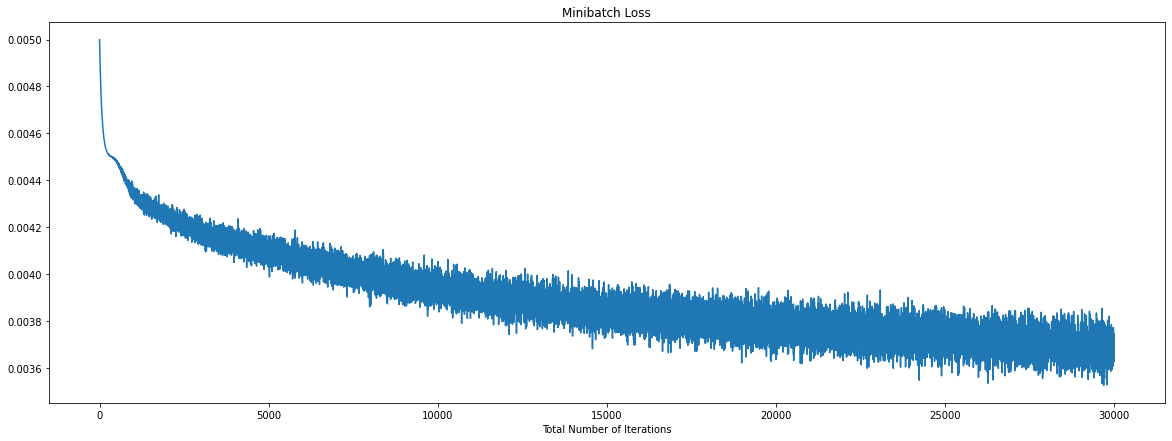

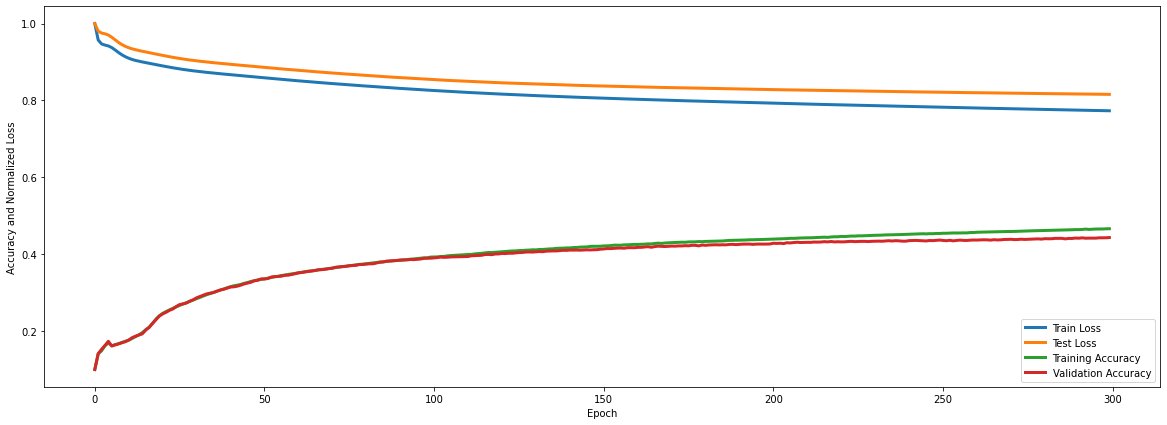

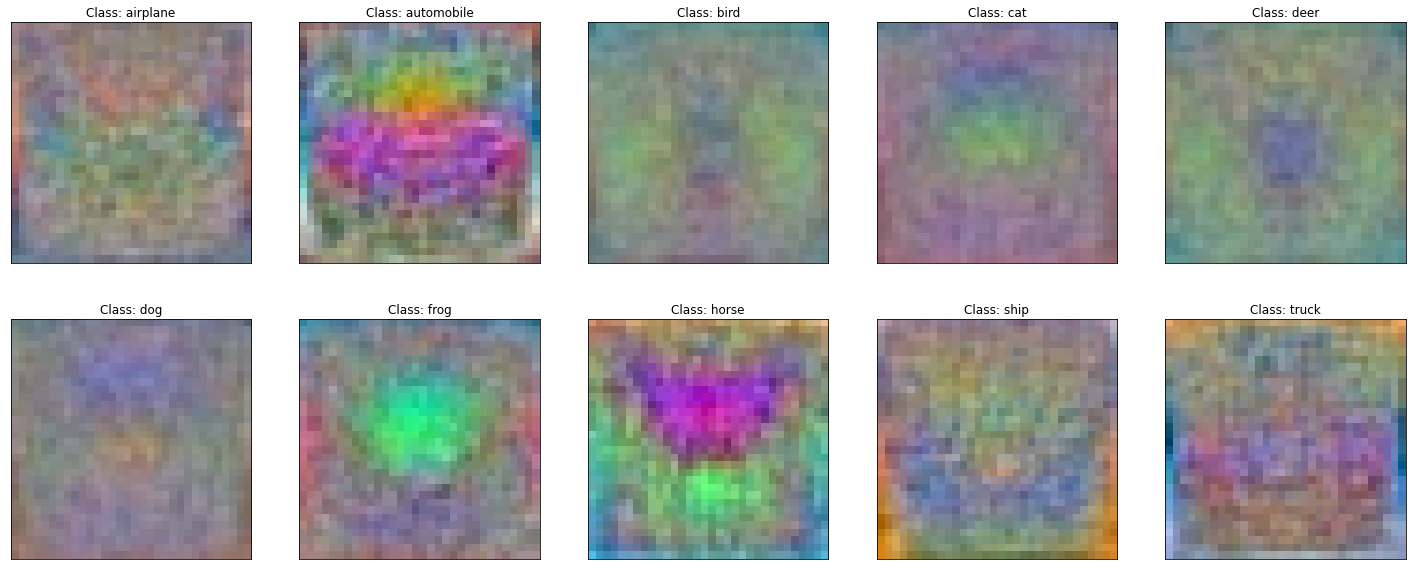

In [12]:
# ----------------------------Plotting Minibatch loss--------------------------
plt.figure(figsize=(20,7))
plt.plot(mini_batch_loss); plt.title('Minibatch Loss')
plt.xlabel("Total Number of Iterations"); #saveto('part3minibloss.eps')

# ------Plotting learning rate, training and testing loss and accuracies-------
# fig, axes  = plt.subplots(1,4, sharex='all', sharey='all', figsize=(30,6))
# items = {"Loss":loss_history, "Training Accuracy %":train_acc_history,\
#          "Validation Accuracy %": val_acc_history, "Learning Rate":lr_hitory}
# location = 1
# for key in items.keys():
#     plt.subplot(1,4,location);plt.plot(items[key], color='#0000ff', linewidth=3)
#     plt.title(key); plt.xlabel('Number of Iterations')
#     location+=1
plt.figure(figsize=(20,7))
plt.plot(loss_history/np.max(loss_history), linewidth=3, label = 'Train Loss')
plt.plot(test_loss/np.max(test_loss), linewidth=3, label = 'Test Loss')
plt.plot(train_acc_history, linewidth=3, label = "Training Accuracy")
plt.plot(val_acc_history,  linewidth=3, label =  "Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy and Normalized Loss')
plt.legend(loc='lower right')
# saveto("part3plots.eps")

# -------------------Showing the weights matrix W1.W2 as 10 images-----------------
weights = w1[1:,].dot(w2[1:,]) # Removing the rows of bias terms.
weights_pos =  weights- np.min(weights)# Making the minimum weight zero.
images = ((weights_pos/np.max(weights_pos))*255).astype('uint8')
CIFAR10 = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
fig, axes  = plt.subplots(2,5, sharex='all', sharey='all', figsize=(25,10))
location = 1 # Location of the image in the grid of 2x5
for i in range(K):
    image = images[:,i].reshape(32,32,3)
    plt.subplot(2,5,location),plt.imshow(image[:,:,::-1])
    plt.title("Class: {}".format(CIFAR10[i])), plt.xticks([]),plt.yticks([]) 
#     saveimg(CIFAR10[i] +".jpg", image)
    location+=1
# saveto("trainedWeightsnn2stochastic.eps")

# Part 4 
Construct a CNN using Keras.models.Sequential (with the following configuration: C32, C64, C64, F64, F10. All three convolutions layers are 3x3. Max pooling (2x2) follows each convolution layer. Use SDG (with momentum) with a batch size of 50 and CategoricalCrossentropy as the loss. [2
marks]
1. How many learnable parameters are there in this network?
2. Report the parameters such as the learning rate and momentum.
3. Report training and testing loss and accuracies.

[Code Reference](https://www.tensorflow.org/tutorials/images/cnn),
[model.fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit),
[CategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy),
[sgd](https://keras.io/api/optimizers/sgd/)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C32 (Conv2D)                 (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
C64_1 (Conv2D)               (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
C64_2 (Conv2D)               (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

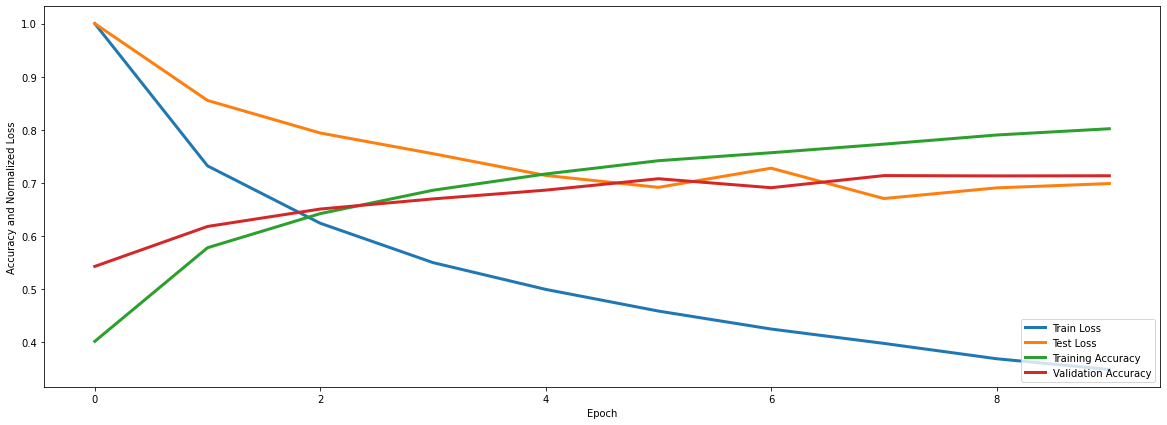

In [13]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
K = len(np.unique(y_train)) # Number of Classes

# Normalize pixel values: Image data preprocessing
x_train, x_test = x_train / 255.0, x_test / 255.0
mean_image = np.mean(x_train, axis=0) # axis=0: mean of a column; Mean of each pixel
x_train = x_train - mean_image
x_test = x_test - mean_image

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes=K)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)

#number of output channels for each Conv2D layer is controlled by the first argument
model = models.Sequential()

# As we go deeper into the model height and widht shrinks
# So we can increase the convolution channels

# 32, 3x3 convolutions
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), name='C32'))
model.add(layers.MaxPooling2D((2, 2)))

# 64, 3x3 convolutions
model.add(layers.Conv2D(64, (3, 3), activation='relu', name='C64_1'))
model.add(layers.MaxPooling2D((2, 2)))

# 64, 3x3 convolutions
model.add(layers.Conv2D(64, (3, 3), activation='relu', name='C64_2'))
model.add(layers.MaxPooling2D((2, 2)))

#feeding the last output tensor from the convolutional base 
#  (of shape (None, 2, 2, 64)) into one or more Dense layers
# Dense layers take vectors as input

model.add(layers.Flatten()) # Make the (None, 2, 2, 64) tensor flat
model.add(layers.Dense(64, activation='relu', name='F64'))

# CIFAR has 10 output classes, final Dense layer should have 10 outputs
model.add(layers.Dense(10, name='F10'))

# Complete architecture of the model
model.summary()

# An optimizer is one of the two arguments required for compiling a Keras model:
# hyperparameter - whose value is used to control the learning process
# momentum: float hyperparameter() >= 0 that accelerates gradient descent 
#  in the relevant direction and dampens oscillations.
# Defaults to 0, i.e., vanilla gradient descent.

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1.4e-2, momentum=0.9),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=50, epochs=10, 
                    validation_data=(x_test, y_test))

plt.figure(figsize=(20,7))
plt.plot(history.history['loss']/np.max(history.history['loss']), linewidth=3, label = 'Train Loss')
plt.plot(history.history['val_loss']/np.max(history.history['val_loss']), linewidth=3, label = 'Test Loss')
plt.plot(history.history['accuracy'], linewidth=3, label = "Training Accuracy")
plt.plot(history.history['val_accuracy'],  linewidth=3, label =  "Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy and Normalized Loss')
plt.legend(loc='lower right')
#saveto("part4plots.eps")
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(test_acc)